### Import Libraries

In [89]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from textwrap import dedent
import json

### Load Embeddings and Pre-computed TF-IDF

In [90]:
# Import embeddings and tfidf df
business_id = '_ab50qdWOk0DdB6XOrBitw'  #'ytynqOUb3hjKeJfRj5Tshw'
reviews_path = f"filtered/business_reviews_{business_id}.parquet"

tfidf_df_path = f"filtered/tfidf_{business_id}.parquet"

reviews_df = pd.read_parquet(reviews_path)
tfidf_df = pd.read_parquet(tfidf_df_path)

In [129]:
reviews_df.shape

(7662, 13)

In [130]:
tfidf_df.shape

(7662, 695)

In [93]:
X = np.vstack(reviews_df.normalized_embeddings.values)

In [94]:
# Mean centering
scaler = StandardScaler(with_std=False)
X_centered = scaler.fit_transform(X)

In [95]:
# PCA with whitening
pca = PCA(n_components=150, whiten=True, random_state=42)
X_white = pca.fit_transform(X_centered)

In [134]:
# cluster function
def evaluate_k_range(X, X_white, k_values_list):
    results = []
    
    for k in k_values_list:
        print(f"Average cluster centroid similarity scores for k={k}...")
        
        # Fit KMeans
        # n_init=10; randomly set cluster centroids 10 different times to land on optimal centroid locations
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        labels = kmeans.fit_predict(X_white)
        
        # Compute RAW centroids from ORIGINAL embeddings
        centroids = np.vstack([
            X[labels == cid].mean(axis=0)
            for cid in range(k)
        ])

        # ----------------------INTRA-CLUSTER COHESION------------------------#
        # Per cluster cohesion
        intra_cosines = []
        for cluster_id in range(k):
            cluster_embs = X[labels == cluster_id]

            if len(cluster_embs) > 1:
                cos_sim = cosine_similarity(cluster_embs)

                # only use upper triangle of the matrix: ignore duplicates and diagonal(exclude self-similarity)
                # k=1, start 1 above diagonal
                upper = cos_sim[np.triu_indices_from(cos_sim, k=1)]
                avg_intra = np.mean(upper)
            else:
                avg_intra = np.nan

            intra_cosines.append(avg_intra)

        # overall theme purity
        # ignore nan(clusters with 1 review)
        avg_intra_cluster_cos = np.nanmean(intra_cosines)
        
        # ----------------------INTER-CLUSTER SEPARATION------------------------#

        # Inter-cluster separation; cosine similarity measure(lower is better)
        # clusters centroid similarity
        centroid_sim_mat = cosine_similarity(centroids)
    
        # only use upper triangle of the matrix: ignore duplicates and diagonal(exclude self-similarity)
        # k=1, start 1 above diagonal
        upper = centroid_sim_mat[np.triu_indices_from(centroid_sim_mat, k=1)]
        
        results.append({
            "k": k,
            "avg_intra_cosine": avg_intra_cluster_cos,
            "inter_centroid_cosine": upper.mean()
        })

    return pd.DataFrame(results)


In [135]:
k_values = range(2, 13)   # test k=2 through 12
results_df = evaluate_k_range(X, X_white, k_values)
results_df

Average cluster centroid similarity scores for k=2...
Average cluster centroid similarity scores for k=3...
Average cluster centroid similarity scores for k=4...
Average cluster centroid similarity scores for k=5...
Average cluster centroid similarity scores for k=6...
Average cluster centroid similarity scores for k=7...
Average cluster centroid similarity scores for k=8...
Average cluster centroid similarity scores for k=9...
Average cluster centroid similarity scores for k=10...
Average cluster centroid similarity scores for k=11...
Average cluster centroid similarity scores for k=12...


,k,avg_intra_cosine,inter_centroid_cosine
0,2,0.415858,0.941164
1,3,0.449716,0.925584
2,4,0.438238,0.869768
3,5,0.449099,0.871265
4,6,0.461799,0.863152
5,7,0.466263,0.856198
6,8,0.469567,0.851153
7,9,0.473420,0.850916
8,10,0.470400,0.733784
9,11,0.466452,0.864616


#### Theme Overlap(Separation) and Theme Impurity(Cohesion)

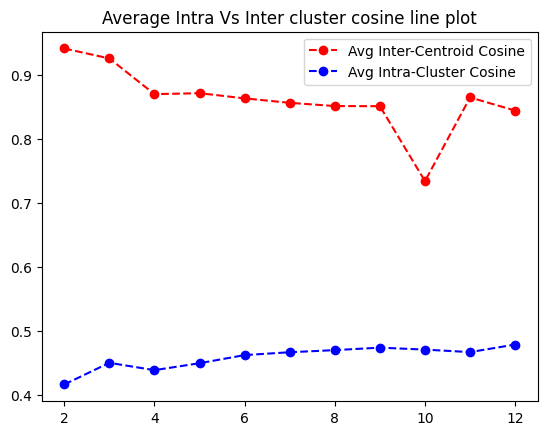

In [136]:
plt.plot(results_df['k'], results_df['inter_centroid_cosine'], marker='o', linestyle='--', c='red', label='Avg Inter-Centroid Cosine')
plt.plot(results_df['k'], results_df['avg_intra_cosine'], marker='o', linestyle='--', c='blue', label='Avg Intra-Cluster Cosine')
plt.title('Average Intra Vs Inter cluster cosine line plot')
plt.legend()
plt.show()

As k increases, intra-cluster cohesion improves while inter-centroid similarity decreases with both curves saturating around k=8-9. This marks an optimal balance between internal theme purity and external theme separation.

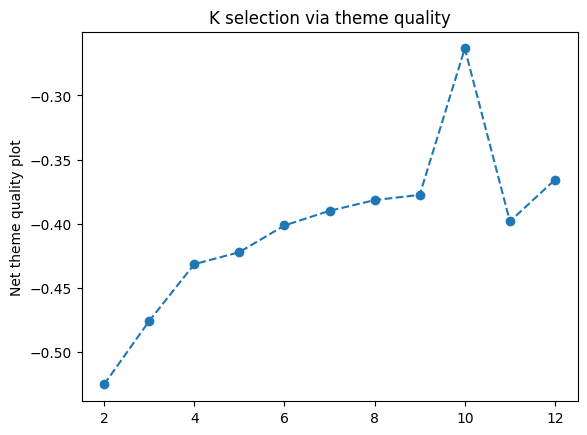

In [137]:
# Net theme quality
plt.plot(results_df['k'], results_df['avg_intra_cosine'] - results_df['inter_centroid_cosine'], marker='o', linestyle='--')
plt.ylabel('Net theme quality plot')
plt.title("K selection via theme quality")
plt.show()

In [138]:
# select best k; true geometric elbow
def select_k(results_df):
    """
    Choose k using an elbow on net-theme quality curve
    """
    df = results_df.copy().sort_values('k')
    k_vals = df.k.values
    net_qual = (df['avg_intra_cosine'] - df['inter_centroid_cosine']).values

    # Normalize for numerical stability
    k_norm = (k_vals - k_vals.min()) / (k_vals.max() - k_vals.min())
    net_qual_norm = (net_qual - net_qual.min()) / (net_qual.max() - net_qual.min())

    # Line between first and last points
    p1 = np.array([k_norm[0], net_qual_norm[0]])
    p2 = np.array([k_norm[-1], net_qual_norm[-1]])

    line_vec = p2 - p1

    # Distance between each point and the line
    distances = []
    for x,y in zip(k_norm, net_qual_norm):
        p = np.array([x, y])

        # distance = area of parallelogram / base length
        dist = np.abs(np.cross(line_vec, p-p1)) / np.linalg.norm(line_vec)

        distances.append(dist)

    distances = np.array(distances)

    # we do not care about endpoints in elbow detection
    distances[0] = 0.0
    distances[-1] = 0.0

    best_idx = distances.argmax()
    best_k = int(k_vals[best_idx])

    return best_k, distances
    

In [139]:
best_k, elbow_distances = select_k(results_df)
print(f"Auto selected k: {best_k}")
print(f"Elbow distances: {elbow_distances}")

Auto selected k: 10
Elbow distances: [0.         0.10915343 0.20167815 0.1801746  0.19600138 0.18119478
 0.15638257 0.11768436 0.43770114 0.05376603 0.        ]


In [104]:
# Run clustering across multiple k
clustering_model = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels = clustering_model.fit_predict(X_white)

In [131]:
labels.shape

(7662,)

In [106]:
# Assign clusters
reviews_df = reviews_df.copy()
reviews_df['cluster'] = labels

In [107]:
reviews_df.head()

,review_id,business_id,stars,text,date,text_cleaned,year,char_count,word_count,avg_word_length,lemmas,normalized_embeddings,cluster
0,vHLTOsdILT7xgTu7TAWTUQ,_ab50qdWOk0DdB6XOrBitw,5.0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,this place has amazing oysters and the best bl...,2016,557,107,5.205607,place amazing oyster well bloody mary stay nol...,"[0.041993144899606705, 0.05851171910762787, 0....",1
1,I90lP6oPICTkrhCFGQt5tA,_ab50qdWOk0DdB6XOrBitw,5.0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh my!! a must try. we had no idea there would...,2016,425,82,5.182927,oh try idea line definitely worth oyster amazi...,"[-0.03591486066579819, -0.03511025756597519, 0...",1
2,469eAl2fB069YTF_B5zW7w,_ab50qdWOk0DdB6XOrBitw,5.0,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39,the fried seafood was extremely hot. very nice...,2018,530,97,5.463918,fried seafood extremely hot nice taste add sof...,"[-0.03977707028388977, 0.028981056064367294, 0...",2
3,aPpHBDs7Jiiq0sb9YutOhQ,_ab50qdWOk0DdB6XOrBitw,5.0,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12,i love this place. i wish my stay was longer s...,2013,193,40,4.825000,love place wish stay long visit food awesome d...,"[-0.0233197920024395, 0.018473675474524498, 0....",0
4,k9OG5kA5ebruSx_f1T-P-A,_ab50qdWOk0DdB6XOrBitw,3.0,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20,"loved the chargrilled oysters! i mean, serious...",2010,1277,230,5.552174,love chargrilled oyster mean seriously tasty c...,"[-0.018412481993436813, 0.05632537975907326, 0...",1


In [108]:
# Extract top terms from each cluster TF-IDF
tfidf_df

,abita,able,absolutely,acme,acme oyster,actually,add,afternoon,ago,alright,...,worth,worth wait,wow,write,wrong,year,yelp,yes,yum,yummy
0,0.0,0.0,0.0,0.099357,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.130940,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.149749,0.000000,0.0,0.0,...,0.171729,0.113493,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.065147,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.137213,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.267375,0.0
7658,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
7659,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
7660,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.114733,0.151650,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [109]:
tf_df = tfidf_df.copy()
tf_df['cluster'] = labels

In [110]:
cluster_top_terms = {}
for c in range(best_k):
    cluster_tf_df = tf_df[tf_df['cluster'] == c].drop(columns='cluster')

    # calculate each words average representation across reviews in that cluster
    cluster_mean_tf_idf = cluster_tf_df.mean(axis=0)

    top_terms = cluster_mean_tf_idf.sort_values(ascending=False).head(10).index.\
                                                                str.replace('TFIDF_', '').\
                                                                tolist()
    
    # select top 10 terms
    cluster_top_terms[c] = top_terms

In [111]:
for k,v in cluster_top_terms.items():
    print(f'cluster {k}: {v}')

cluster 0: ['orleans', 'new orleans', 'new', 'good', 'place', 'food', 'acme', 'line', 'wait', 'great']
cluster 1: ['good', 'wait', 'line', 'place', 'order', 'grill', 'chargrilled', 'chargrilled oyster', 'worth', 'raw']
cluster 2: ['good', 'great', 'place', 'shrimp', 'line', 'food', 'boy', 'wait', 'crab', 'po']
cluster 3: ['food', 'good', 'wait', 'line', 'service', 'place', 'great', 'come', 'order', 'long']


In [112]:
# Select cluster represenatative reviews; closest to cluster centroid
# centroids
centroids = clustering_model.cluster_centers_

representative_reviews_ids = {}

num_of_examples = 5

for c in range(best_k):
    cluster_idx = np.where(reviews_df.cluster.values == c)[0]

    # Get their embeddings
    cluster_vecs = X_white[cluster_idx]

    # similarity to this cluster centroid
    sims = cosine_similarity(cluster_vecs, centroids[c].reshape(1, -1)).ravel()

    top_examples_ids = np.argsort(sims)[-num_of_examples:]

    representative_reviews_ids[c] = cluster_idx[top_examples_ids].tolist()

In [113]:
representative_reviews_ids

{0: [4282, 5550, 6209, 276, 4274],
 1: [3685, 2322, 392, 7195, 5011],
 2: [3358, 723, 458, 6488, 2547],
 3: [6812, 6839, 87, 1484, 1683]}

In [114]:
# LLM cluster labelling

def generate_theme(cid, terms, examples):
    examples_text = "\n---\n".join(
        [f"- {e}" for e in examples]
    )

    prompt = dedent(f"""
    You are an expert in customer experience analytics.

    You are analyzing a cluster of customer reviews

    Cluster ID: {cid}

    Top TF-IDF Terms:
    {terms}

    Representative Reviews:
    {examples_text}

    Return your response as VALID JSON ONLY in this exact schema:

    {{
        "theme_name": "",
        "summary": "",
        "likes": ["", ""],
        "dislikes": ["", ""],
        "business_impact": ""
    }}

    RULES:
    - Do NOT include markdown
    - Do NOT include explanations
    - Do NOT include extra text outside the JSON
    - Keep the theme name to 3-5 words
    - Keep it concise, specific, and business-friendly.
    """)

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "system", 
                   "content": ("You are an expert in customer experience analytics."
                               "You MUST return ONLY valid JSON that strictly follows the provided schema."
                               "Do not include markdown, comments or extra text."
                              )
                  },
                  {"role": "user", 
                   "content": prompt}],
        temperature=0.3
    )

    return json.loads(response.choices[0].message.content)

In [115]:
# Load .env
from dotenv import load_dotenv
load_dotenv()

True

In [116]:
# Create connect to OPENAI API
from openai import OpenAI
client = OpenAI()

In [117]:
examples = reviews_df.loc[representative_reviews_ids[0], 'text'].tolist()

generate_theme(0, cluster_top_terms[0], examples)

{'theme_name': 'New Orleans Dining Experience',
 'summary': 'Customers appreciate the food quality and iconic status of the restaurant, but express concerns about wait times and tourist crowds.',
 'likes': ['Great food variety', 'Iconic New Orleans experience'],
 'dislikes': ['Long wait times', 'Tourist-heavy atmosphere'],
 'business_impact': 'Positive reputation but potential need to manage wait times and customer flow.'}

In [118]:
theme_cards = {}
for c in range(best_k):
    examples = reviews_df.loc[representative_reviews_ids[c], 'text'].tolist()
    
    # save generate_theme response for each cluster
    theme_cards[c] = generate_theme(c, cluster_top_terms[c], examples)


In [119]:
theme_cards

{0: {'theme_name': 'New Orleans Dining Experience',
  'summary': 'Customers appreciate the food quality and iconic status of the restaurant, but express concerns about long wait times and tourist crowds.',
  'likes': ['Great food quality', 'Iconic New Orleans experience'],
  'dislikes': ['Long wait times', 'Tourist crowds'],
  'business_impact': 'Maintaining food quality while managing wait times could enhance customer satisfaction.'},
 1: {'theme_name': 'Oysters and Wait Times',
  'summary': 'Customers rave about the freshness and flavor of both raw and chargrilled oysters, though some mention long wait times.',
  'likes': ['Fresh and delicious oysters', 'Friendly service and atmosphere'],
  'dislikes': ['Long wait times for seating',
   'Inconsistent portion sizes for some dishes'],
  'business_impact': 'Positive reviews on oysters can drive repeat visits, but addressing wait times may improve overall customer satisfaction.'},
 2: {'theme_name': 'Oyster and Shrimp Experience',
  'sum

In [120]:
reviews_df.year.describe()

count    7662.000000
mean     2015.873140
std         3.114629
min      2006.000000
25%      2014.000000
50%      2016.000000
75%      2018.000000
max      2022.000000
Name: year, dtype: float64

In [121]:
reviews_df

,review_id,business_id,stars,text,date,text_cleaned,year,char_count,word_count,avg_word_length,lemmas,normalized_embeddings,cluster
0,vHLTOsdILT7xgTu7TAWTUQ,_ab50qdWOk0DdB6XOrBitw,5.0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,this place has amazing oysters and the best bl...,2016,557,107,5.205607,place amazing oyster well bloody mary stay nol...,"[0.041993144899606705, 0.05851171910762787, 0....",1
1,I90lP6oPICTkrhCFGQt5tA,_ab50qdWOk0DdB6XOrBitw,5.0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh my!! a must try. we had no idea there would...,2016,425,82,5.182927,oh try idea line definitely worth oyster amazi...,"[-0.03591486066579819, -0.03511025756597519, 0...",1
2,469eAl2fB069YTF_B5zW7w,_ab50qdWOk0DdB6XOrBitw,5.0,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39,the fried seafood was extremely hot. very nice...,2018,530,97,5.463918,fried seafood extremely hot nice taste add sof...,"[-0.03977707028388977, 0.028981056064367294, 0...",2
3,aPpHBDs7Jiiq0sb9YutOhQ,_ab50qdWOk0DdB6XOrBitw,5.0,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12,i love this place. i wish my stay was longer s...,2013,193,40,4.825000,love place wish stay long visit food awesome d...,"[-0.0233197920024395, 0.018473675474524498, 0....",0
4,k9OG5kA5ebruSx_f1T-P-A,_ab50qdWOk0DdB6XOrBitw,3.0,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20,"loved the chargrilled oysters! i mean, serious...",2010,1277,230,5.552174,love chargrilled oyster mean seriously tasty c...,"[-0.018412481993436813, 0.05632537975907326, 0...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,bax2r1CzIbGAFl3s45V2mg,_ab50qdWOk0DdB6XOrBitw,3.0,Came here about 2pm on a rainy Sunday afternoo...,2013-12-27 15:36:07,came here about 2pm on a rainy sunday afternoo...,2013,768,144,5.333333,come pm rainy sunday afternoon seat right away...,"[0.04539003595709801, 0.04047146812081337, 0.0...",1
7658,d5LAa5CvdLyyze89810DWQ,_ab50qdWOk0DdB6XOrBitw,5.0,"Once I walked near this place, I knew that I h...",2018-07-01 04:36:45,"once i walked near this place, i knew that i h...",2018,326,70,4.657143,walk near place know eat wish take picture lin...,"[0.028752749785780907, 0.10838160663843155, 0....",3
7659,z-tXUBHlqMtnHbta6rFNDA,_ab50qdWOk0DdB6XOrBitw,5.0,Tip- get there just a little early (like right...,2019-07-27 15:26:25,tip- get there just a little early (like right...,2019,644,126,5.111111,little early like right wait come town ask bar...,"[0.07028381526470184, 0.04205452650785446, 0.0...",1
7660,BSkhHEd4bKwuzy4gbU8NFA,_ab50qdWOk0DdB6XOrBitw,5.0,All I can say about this place is it is one of...,2015-05-20 23:05:09,all i can say about this place is it is one of...,2015,555,108,5.138889,place place eat know amazingly good like oyste...,"[0.04445233568549156, 0.01901945099234581, 0.0...",1


In [122]:
# Evaluating concept drift, do changes happen that affect theme changes year-over-year
year_cluster_dist = reviews_df.groupby(['cluster', 'year']).size().reset_index(name="count")

In [123]:
print(year_cluster_dist)

    cluster  year  count
0         0  2006      1
1         0  2007      4
2         0  2008     11
3         0  2009     46
4         0  2010     63
..      ...   ...    ...
63        3  2018    161
64        3  2019    148
65        3  2020     69
66        3  2021     57
67        3  2022      2

[68 rows x 3 columns]


In [124]:
pivot_df = year_cluster_dist.pivot(index="year", columns="cluster", values="count").fillna(0)

In [125]:
pivot_df

cluster,0,1,2,3
year,,,,
2006,1,2,5,1
2007,4,5,5,1
2008,11,22,21,5
2009,46,48,56,23
2010,63,89,64,24
2011,70,143,84,50
2012,63,143,116,45
2013,92,207,172,64
2014,91,257,195,87


In [126]:
cluster_yrly_pct = pivot_df.div(pivot_df.sum(axis=0), axis=1)

In [127]:
def detect_time_dominance(cluster_yrly_pct, threshold=0.7):
    dominant_flags = {}
    for c in cluster_yrly_pct.columns:
        max_frac = cluster_yrly_pct[c].max()
        dom_year = cluster_yrly_pct[c].idxmax()

        dominant_flags[c] = {
            "dominant_year" : int(dom_year),
            "max_fraction" : float(max_frac),
            "is_time_dominant": bool(max_frac >= threshold)
        }
    return dominant_flags

In [128]:
time_dominance = detect_time_dominance(cluster_yrly_pct)
time_dominance

{0: {'dominant_year': 2018,
  'max_fraction': 0.12981904012588513,
  'is_time_dominant': False},
 1: {'dominant_year': 2018,
  'max_fraction': 0.15060240963855423,
  'is_time_dominant': False},
 2: {'dominant_year': 2018,
  'max_fraction': 0.14803024273776363,
  'is_time_dominant': False},
 3: {'dominant_year': 2018,
  'max_fraction': 0.15246212121212122,
  'is_time_dominant': False}}